### **Hypothesis 5**:
The review/score is influenced by the category of the book
   - **Metric**: Popularity: average review/score
   - **Hypotheses**:
     - **H0**: The rating score is not related to the `categories`, as all rating scores originate from the same distribution. If we consider the rating score of each category, they have the same mean and variance.

     - **H1**: The rating score is affected by the category, meaning the rating scores of each category follow a different distribution.

For the sake of consistency in this analysis, categories with fewer than 20 reviews are excluded. This is because a lower number of reviews is insufficient to significantly estimate statistical measures.

In [1]:
# Import libraries

import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import scipy_analyze as sa

In [2]:
# Connect to MongoDB

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_joined']

In [3]:
# Define the aggregation pipeline
from numpy import NaN


pipeline = [
    {
        "$project": {
            'review/score': 1,
            'categories': 1,
        }
    },
    {'$match': {
        'review/score': {'$exists': True, '$ne': 0.0},
        'categories': {'$exists': True, '$ne': None},
    }
    }
]

# Execute the aggregation query and create a DataFrame
source_df = pd.DataFrame(list(books.aggregate(pipeline)))
source_df = source_df.drop('_id', axis=1)
source_df

,categories,review/score
0,['Biography & Autobiography'],1.0
1,"['Knowledge, Theory of']",1.0
2,"['Knowledge, Theory of']",4.0
3,['Biography & Autobiography'],5.0
4,['Biography & Autobiography'],5.0
...,...,...
300220,['Adolescence'],3.0
300221,['Religion'],5.0
300222,['Religion'],5.0
300223,['Religion'],5.0


In [4]:
category_stats = source_df.groupby('categories').mean()


category_stats['Std_review_score'] = source_df.groupby('categories').std()
category_stats['N_reviews'] = source_df['categories'].value_counts()

category_stats = category_stats.sort_values(by='review/score', ascending=False)

category_stats.reset_index(inplace=True)

category_stats.columns = ['categories',
                      'Mean_review/score', 'Std_review_score', 'N_reviews']

category_stats = category_stats[category_stats['N_reviews'] >= 5]
category_stats = category_stats.sort_values(by='Std_review_score', ascending=False)
category_stats

,categories,Mean_review/score,Std_review_score,N_reviews
4357,['Beast of the Apocalypse'],3.400000,2.190890,5
4348,['Holy Spirit'],3.400000,2.190890,5
4683,['Abused children'],3.000000,2.190890,6
4353,['Mysteries of the Rosary'],3.400000,2.190890,5
4819,['Pedophilia'],2.333333,2.065591,6
...,...,...,...,...
1160,['Haiti'],5.000000,0.000000,5
1117,"['Sicilian Vespers, 1282']",5.000000,0.000000,8
1034,['Meditation'],5.000000,0.000000,8
1004,['Piano'],5.000000,0.000000,6


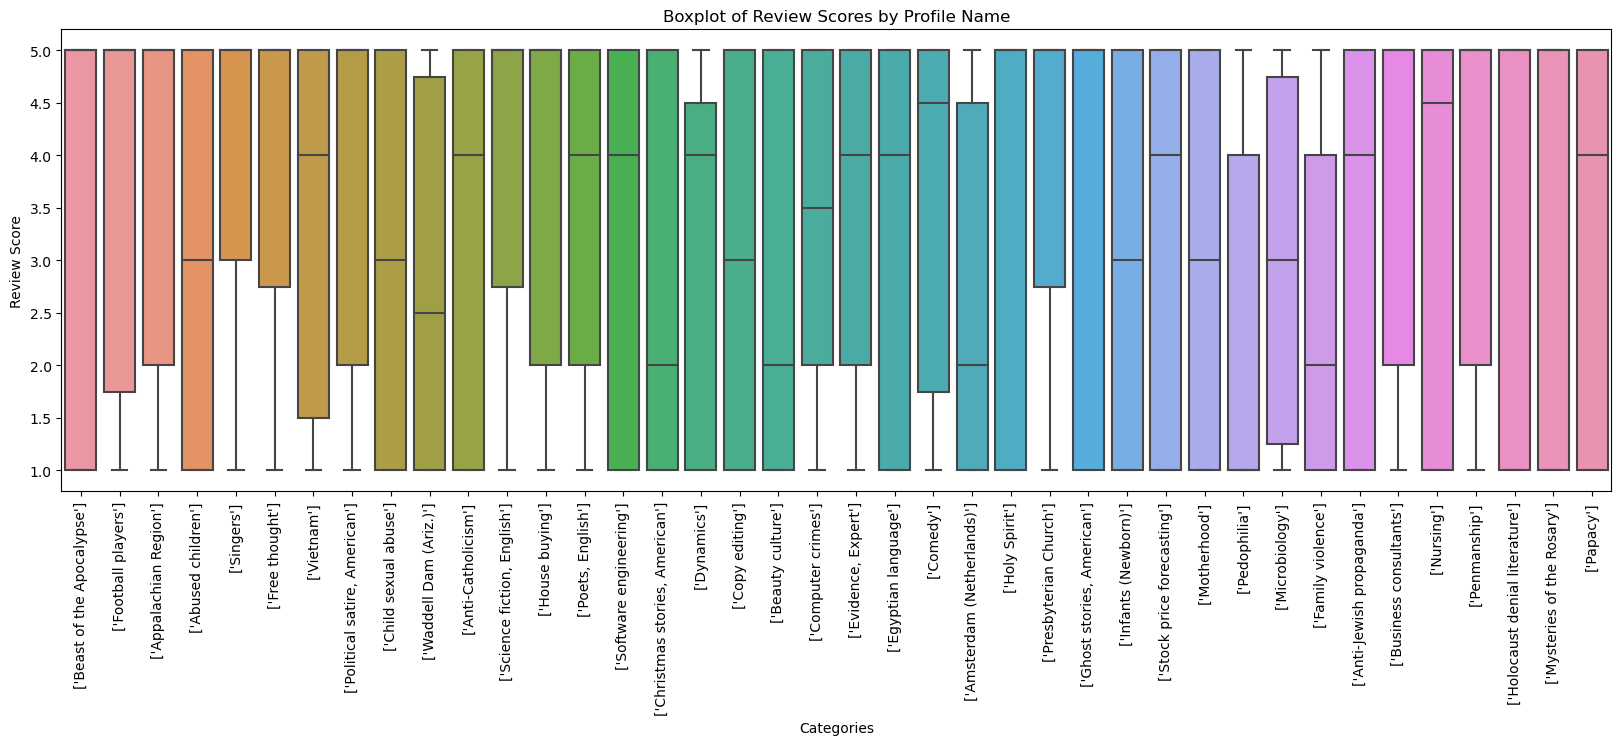

In [5]:
subsample_stat = category_stats.head(40)
df_to_show = source_df.merge(subsample_stat, on='categories', how='inner')
df_to_show = df_to_show[['categories', 'review/score']]

# Create a boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(x='categories', y='review/score', data=df_to_show)
plt.title('Boxplot of Review Scores by Profile Name')
plt.ylabel('Review Score')
plt.xlabel('Categories')
plt.xticks(rotation=90)

# Show the plot
plt.show()

### Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.  
The groups are the profileNames.  
Results of the test :
- F-statistic (F-statistic):
  The F-statistic is a test statistic generated by the ANOVA test. It measures the ratio of the variation between group means to the variation within the groups.
  A larger F-statistic indicates a greater difference in means among the groups relative to the variation within the groups.
  In the context of ANOVA, a larger F-statistic is more likely to lead to the rejection of the null hypothesis, suggesting that there are significant differences among the groups.

  
- P-value (p_value):
  The p-value is a measure of the evidence against the null hypothesis (H0) in statistical hypothesis testing.
  It represents the probability of observing the results (or more extreme results) if the null hypothesis were true.
  In the context of ANOVA, a small p-value (typically less than your chosen significance level, e.g., 0.05) suggests that the differences in means among the groups are statistically significant.
  Conversely, a large p-value suggests that the observed differences could have occurred by random chance, and you fail to reject the null hypothesis.

In [6]:
subset_df = source_df.merge(subsample_stat, on='categories', how='inner')
subset_df = subset_df[['categories', 'review/score']]

# Group scores by user
user_groups = [subset_df['review/score'][subset_df['categories'] == user]
               for user in subset_df['categories'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*user_groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 0.2640612493016393
P-value: 0.9999979735492271


### Conclusion
Based on the analysis, the F-statistic is quite low, and the associated p-value is approximately 1. As a result, we do not have sufficient evidence to reject the null hypothesis, denoted as **H0**. Therefore, we cannot conclude that the rating scores are influenced by the category.
